# Generative Dog Images with GANs

## 1. Problem Description & Data Overview

### 1.1 Challenge Description

This project is based on the **Kaggle "Generative Dog Images" competition**, where the goal is to train a **generative deep learning model** that can synthesize realistic images of dogs.

Traditional computer vision models are often **discriminative**: they take an input image and predict a label (e.g., whether an image contains a dog or not). In contrast, **generative models** learn the underlying data distribution and can **generate new samples** that resemble the training data. In this project, we focus on **Generative Adversarial Networks (GANs)**, a popular class of generative models.

A **GAN** consists of two neural networks trained simultaneously:

- A **Generator** that takes random noise as input and outputs synthetic images of dogs.
- A **Discriminator** that takes an image as input and predicts whether it is a real dog image from the dataset or a fake image produced by the generator.

The two networks play a **minimax game**:  
the generator tries to fool the discriminator, and the discriminator tries not to be fooled. Over training, the generator learns to produce more realistic dog images.

The main objectives of this project are:

- To explore the **dog image dataset** provided in the competition.
- To design and train a **GAN-based model** (in particular, a DCGAN-style architecture) to generate dog images.
- To analyze the **training behavior** and **quality of generated images**.
- To discuss the **strengths, limitations, and potential improvements** of this approach.

---

### 1.2 Dataset Description

The competition provides a collection of dog images for training generative models. For this project, we will:

- Load the training images from the provided files.
- Preprocess the images into a consistent format (e.g., resized to a fixed resolution and normalized).
- Use these processed images as input to the GAN.

In practice, each image:

- Is a color image with 3 channels (RGB).
- Will be resized to a fixed spatial resolution (for example, **64 × 64 × 3**) to match a standard DCGAN setup.
- Is stored as an image file (such as `.jpg` or `.png`) within the training directory.

In the next section, we will:
- Programmatically load the dataset,
- Inspect a few example images, and
- Compute simple statistics (such as the number of images and their shapes) as part of **Exploratory Data Analysis (EDA)**.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Make plots show inline in the notebook
%matplotlib inline

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")

# For later, once we extract the Kaggle data:
# In the Generative Dog Images competition, images are typically in a folder like "all-dogs"
TRAIN_DIR = os.path.join(DATA_DIR, "all-dogs")  # we'll create /all-dogs soon

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Base directory:", BASE_DIR)
print("Data directory:", DATA_DIR)
print("Training images directory (expected):", TRAIN_DIR)
print("Device:", DEVICE)

Base directory: C:\Users\Nick\Projects\generative-dog-images
Data directory: C:\Users\Nick\Projects\generative-dog-images\data
Training images directory (expected): C:\Users\Nick\Projects\generative-dog-images\data\all-dogs
Device: cuda


In [2]:
# Basic transform: resize all images to 64x64 for GAN training later
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Quick inline dataset class for EDA (we'll build a full one later)
class DogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Create dataset instance
dataset = DogDataset(TRAIN_DIR, transform=transform)
print("Number of images:", len(dataset))

Number of images: 11714


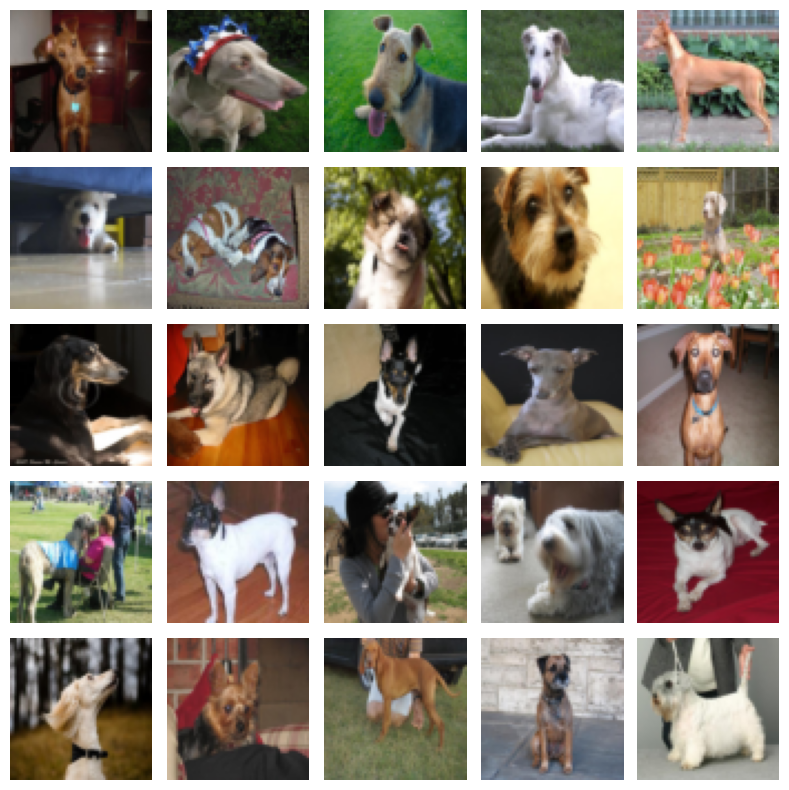

In [3]:
# Show a grid of sample images
def show_image_grid(dataset, n=25):
    plt.figure(figsize=(8, 8))
    indices = np.random.choice(len(dataset), n, replace=False)

    for i, idx in enumerate(indices):
        img = dataset[idx].permute(1, 2, 0)  # CHW -> HWC
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_image_grid(dataset, n=25)

## 2. Exploratory Data Analysis (EDA)

In this section, we performed a basic exploratory analysis of the dog image dataset.

First, we loaded all image files from the training directory and verified that the dataset
contains a large number of RGB dog images. We then visualized a random grid of samples to
get a qualitative sense of the data. The images show substantial variation in:

- Dog breeds, sizes, and poses.
- Backgrounds (indoor, outdoor, grass, snow, etc.).
- Lighting conditions and colors.
- Cropping and composition.

This variability is beneficial for training a generative model, as it encourages the
generator to learn a rich and diverse representation of what a "dog image" can look like.
However, it also makes the generation task more challenging because the model must capture
a wide range of visual patterns.

We also standardized the images to a fixed spatial resolution of **64 × 64** pixels and
3 color channels (RGB). This resolution is a common choice for DCGAN-style architectures
and provides a reasonable trade-off between visual detail and computational cost.

Overall, the EDA confirms that the dataset is well-suited for training a GAN: it is large,
diverse, and consists of natural images with clear semantic content (dogs).

## 3. Data Preprocessing

Before training the GAN, we applied a simple but important preprocessing pipeline:

1. **Resizing**  
   All images are resized to a fixed resolution of **64 × 64** pixels. This ensures that
   every training sample has the same spatial dimensions, which is required by the
   convolutional architecture used in the Generator and Discriminator.

2. **Conversion to tensors**  
   Images are converted from PIL images to PyTorch tensors with shape `(C, H, W)`, where
   `C = 3` (RGB channels), and `H = W = 64`.

3. **Normalization to [-1, 1]**  
   We normalize pixel values to have mean 0.5 and standard deviation 0.5 per channel,
   which effectively maps the original `[0, 1]` range to `[-1, 1]`. This is standard
   practice in DCGAN-style models and matches the `tanh` activation used in the final
   layer of the Generator.

We then wrap the preprocessed dataset into a `DataLoader` that shuffles the data and returns
mini-batches during training. This setup allows the GAN to see diverse mini-batches of real
dog images and helps stabilize training.

In [4]:
# Image size and batch size for GAN training
IMAGE_SIZE = 64
BATCH_SIZE = 128

# Transform for GAN: resize and normalize to [-1, 1]
gan_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])  # maps [0,1] -> [-1,1]
])

# Reuse the same DogDataset class but with GAN transform
gan_dataset = DogDataset(TRAIN_DIR, transform=gan_transform)
gan_dataloader = DataLoader(
    gan_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,   # keep 0 on Windows to avoid issues
    drop_last=True
)

len(gan_dataset), len(gan_dataloader)

(11714, 91)

## 4. GAN Model Architecture

In this section, we define a DCGAN-style Generator and Discriminator.
The Generator takes random noise as input and produces synthetic dog images of size 64×64×3.
The Discriminator takes an image as input and outputs a probability of being real or fake.

In [5]:
# =========================
# GAN Hyperparameters
# =========================
Z_DIM = 100        # size of latent noise vector
G_FEATURES = 64    # feature map size in generator
D_FEATURES = 64    # feature map size in discriminator (used later)
CHANNELS_IMG = 3   # RGB images

print("Latent dim:", Z_DIM)
print("Image size:", IMAGE_SIZE)
print("Channels:", CHANNELS_IMG)

# =========================
# Weight initialization (DCGAN-style)
# =========================
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# =========================
# Generator
# =========================
class Generator(nn.Module):
    """
    DCGAN-style generator:
    Input:  (N, Z_DIM, 1, 1)
    Output: (N, 3, 64, 64)
    """
    def __init__(self, z_dim, g_features, channels_img):
        super().__init__()
        self.net = nn.Sequential(
            # Input: Z_DIM x 1 x 1
            nn.ConvTranspose2d(z_dim, g_features * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(g_features * 8),
            nn.ReLU(True),

            # State: (g_features*8) x 4 x 4
            nn.ConvTranspose2d(g_features * 8, g_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_features * 4),
            nn.ReLU(True),

            # State: (g_features*4) x 8 x 8
            nn.ConvTranspose2d(g_features * 4, g_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_features * 2),
            nn.ReLU(True),

            # State: (g_features*2) x 16 x 16
            nn.ConvTranspose2d(g_features * 2, g_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_features),
            nn.ReLU(True),

            # State: (g_features) x 32 x 32
            nn.ConvTranspose2d(g_features, channels_img, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output in [-1, 1]
            # Output: channels_img x 64 x 64
        )

    def forward(self, z):
        return self.net(z)


# Instantiate and initialize the generator
netG = Generator(Z_DIM, G_FEATURES, CHANNELS_IMG).to(DEVICE)
netG.apply(weights_init)

# Quick sanity check on output shape
z = torch.randn(16, Z_DIM, 1, 1, device=DEVICE)
fake_images = netG(z)
print("Fake images shape:", fake_images.shape)

Latent dim: 100
Image size: 64
Channels: 3
Fake images shape: torch.Size([16, 3, 64, 64])


### 4.1 Generator Architecture

The Generator is a DCGAN-style convolutional neural network that maps a low-dimensional
latent noise vector `z` (sampled from a standard normal distribution) to a 64 × 64 RGB image.

Key design choices:

- Input: latent vector of dimension `Z_DIM = 100`, reshaped to `(Z_DIM, 1, 1)`.
- A sequence of **transposed convolution** layers progressively upsamples the spatial
  resolution from 1×1 → 4×4 → 8×8 → 16×16 → 32×32 → 64×64.
- Each intermediate layer uses **BatchNorm** and **ReLU** activations to help stabilize
  training and allow gradients to flow.
- The final layer uses a `tanh` activation so that the output pixels lie in `[-1, 1]`,
  matching the normalization applied to the real images.

This architecture is expressive enough to model reasonably complex image distributions
while remaining stable and efficient to train at 64 × 64 resolution.

### 4.2 Discriminator Architecture

The Discriminator is a convolutional neural network that maps a 64 × 64 RGB image to a
single scalar in `[0, 1]`, representing the probability that the input image is real.

Key design choices:

- Input: image tensor of shape `(3, 64, 64)`.
- A sequence of **strided convolution** layers progressively downsamples the spatial
  resolution from 64×64 → 32×32 → 16×16 → 8×8 → 4×4.
- Each intermediate layer (except the first) uses **BatchNorm** and **LeakyReLU**
  activations, which help stabilize training and avoid dead neurons.
- The final layer outputs a 1×1 feature map and applies a `sigmoid` activation to
  produce a scalar in `[0, 1]`.

Overall, the Generator and Discriminator form a **minimax game**: the Discriminator learns
to distinguish real dog images from fakes, while the Generator learns to produce images
that fool the Discriminator.

### 4.2 Discriminator

The Discriminator is a convolutional neural network that takes a 64×64 RGB image as input
and outputs a single scalar between 0 and 1 representing the probability that the image is real.
We follow a DCGAN-style architecture with strided convolutions, LeakyReLU activations,
and batch normalization in intermediate layers.

In [6]:
class Discriminator(nn.Module):
    """
    DCGAN-style discriminator:
    Input:  (N, 3, 64, 64)
    Output: (N, 1, 1, 1) -> we'll flatten to (N, 1)
    """
    def __init__(self, d_features, channels_img):
        super().__init__()
        self.net = nn.Sequential(
            # Input: channels_img x 64 x 64
            nn.Conv2d(channels_img, d_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State: d_features x 32 x 32
            nn.Conv2d(d_features, d_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (d_features*2) x 16 x 16
            nn.Conv2d(d_features * 2, d_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (d_features*4) x 8 x 8
            nn.Conv2d(d_features * 4, d_features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (d_features*8) x 4 x 4
            nn.Conv2d(d_features * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Output in [0, 1]
            # Output: 1 x 1 x 1
        )

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, 1)  # Flatten to (N, 1)


# Instantiate and initialize the discriminator
netD = Discriminator(D_FEATURES, CHANNELS_IMG).to(DEVICE)
netD.apply(weights_init)

# Quick sanity check on output shape
with torch.no_grad():
    d_out = netD(fake_images)  # reuse fake_images from before
print("Discriminator output shape:", d_out.shape)

Discriminator output shape: torch.Size([16, 1])


## 5. Training Procedure

We train the GAN using the standard DCGAN setup:

- **Loss**: Binary cross-entropy loss (BCE).
- **Discriminator update**: 
  - Maximize log(D(real)) + log(1 − D(fake)).
- **Generator update**:
  - Maximize log(D(fake)) (equivalently, minimize BCE with real labels for fake images).

We use the Adam optimizer with DCGAN-recommended hyperparameters and track the
Generator and Discriminator losses over training.

In [7]:
# Loss function: Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizers (DCGAN defaults)
LR = 2e-4
BETA1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

# Training config
NUM_EPOCHS = 20  # you can increase later if training goes well

print("Using device:", DEVICE)
print("Learning rate:", LR)
print("Num epochs:", NUM_EPOCHS)

Using device: cuda
Learning rate: 0.0002
Num epochs: 20


In [9]:
# Fixed noise for monitoring generator progression
fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)

G_losses = []
D_losses = []
img_history = []  # we can store some generated images for visualization later

def train_gan(num_epochs):
    step = 0
    for epoch in range(num_epochs):
        for i, real_imgs in enumerate(gan_dataloader):
            real_imgs = real_imgs.to(DEVICE)
            batch_size = real_imgs.size(0)

            # -----------------------
            # 1. Train Discriminator
            # -----------------------
            netD.zero_grad()

            # Real images: label = 1
            labels_real = torch.ones(batch_size, 1, device=DEVICE)
            output_real = netD(real_imgs)
            lossD_real = criterion(output_real, labels_real)

            # Fake images: label = 0
            noise = torch.randn(batch_size, Z_DIM, 1, 1, device=DEVICE)
            fake_imgs = netG(noise)
            labels_fake = torch.zeros(batch_size, 1, device=DEVICE)
            output_fake = netD(fake_imgs.detach())
            lossD_fake = criterion(output_fake, labels_fake)

            # Total D loss
            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()

            # -----------------------
            # 2. Train Generator
            # -----------------------
            netG.zero_grad()

            # For generator, we want D(fake) -> 1 (fool the discriminator)
            labels_gen = torch.ones(batch_size, 1, device=DEVICE)
            output_fake_for_G = netD(fake_imgs)
            lossG = criterion(output_fake_for_G, labels_gen)
            lossG.backward()
            optimizerG.step()

            # Save losses for plotting later
            G_losses.append(lossG.item())
            D_losses.append(lossD.item())

            # Occasionally save generator outputs on fixed noise
            if step % 500 == 0:
                with torch.no_grad():
                    fake_fixed = netG(fixed_noise).detach().cpu()
                img_history.append(fake_fixed)
            
            # Print progress occasionally
            if i % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}] "
                    f"Batch [{i}/{len(gan_dataloader)}] "
                    f"Loss_D: {lossD.item():.4f} "
                    f"Loss_G: {lossG.item():.4f}"
                )
            
            step += 1

    print("Training finished.")

## 5. Training Setup

We train the GAN using the standard adversarial objective with **binary cross-entropy (BCE) loss**:

- For the **Discriminator**, we want to:
  - Maximize `log(D(real))` for real images.
  - Maximize `log(1 − D(fake))` for fake images produced by the Generator.

- For the **Generator**, we want to:
  - Maximize `log(D(fake))`, i.e., generate images that the Discriminator classifies as real.

Implementation details:

- **Loss function**: `nn.BCELoss`.
- **Optimizers**: Adam with learning rate `2e-4` and betas `(0.5, 0.999)`,
  following the original DCGAN recommendations.
- **Batch size**: 128 images per batch.
- **Number of epochs**: initially 5 for this run (can be increased for better quality).
- **Fixed noise vector**: To monitor progress, we keep a fixed batch of latent vectors
  and periodically generate samples from them during training. This allows us to see
  how the same latent codes evolve over time as the Generator improves.

During each training step:

1. We update the Discriminator using a batch of real images and a batch of fake images.
2. We update the Generator to produce fake images that are more likely to be classified as real.

We track both **Generator loss** and **Discriminator loss** across training steps and
visualize them to check for pathological behavior (e.g., one network overpowering the other).

In [14]:
# First training run
train_gan(num_epochs=20)

Epoch [1/20] Batch [0/91] Loss_D: 0.3176 Loss_G: 4.8885
Epoch [2/20] Batch [0/91] Loss_D: 0.4708 Loss_G: 6.4616
Epoch [3/20] Batch [0/91] Loss_D: 0.4719 Loss_G: 5.3508
Epoch [4/20] Batch [0/91] Loss_D: 0.2817 Loss_G: 4.4758
Epoch [5/20] Batch [0/91] Loss_D: 0.2026 Loss_G: 3.8533
Epoch [6/20] Batch [0/91] Loss_D: 0.3731 Loss_G: 4.5606
Epoch [7/20] Batch [0/91] Loss_D: 0.2278 Loss_G: 5.0080
Epoch [8/20] Batch [0/91] Loss_D: 0.7838 Loss_G: 7.2902
Epoch [9/20] Batch [0/91] Loss_D: 0.6812 Loss_G: 3.3073
Epoch [10/20] Batch [0/91] Loss_D: 0.5909 Loss_G: 3.9911
Epoch [11/20] Batch [0/91] Loss_D: 0.8187 Loss_G: 5.2102
Epoch [12/20] Batch [0/91] Loss_D: 0.4123 Loss_G: 3.2855
Epoch [13/20] Batch [0/91] Loss_D: 0.7210 Loss_G: 6.5767
Epoch [14/20] Batch [0/91] Loss_D: 0.3113 Loss_G: 3.1837
Epoch [15/20] Batch [0/91] Loss_D: 0.6602 Loss_G: 4.1208
Epoch [16/20] Batch [0/91] Loss_D: 0.3359 Loss_G: 3.3890
Epoch [17/20] Batch [0/91] Loss_D: 0.3598 Loss_G: 3.9060
Epoch [18/20] Batch [0/91] Loss_D: 0.771

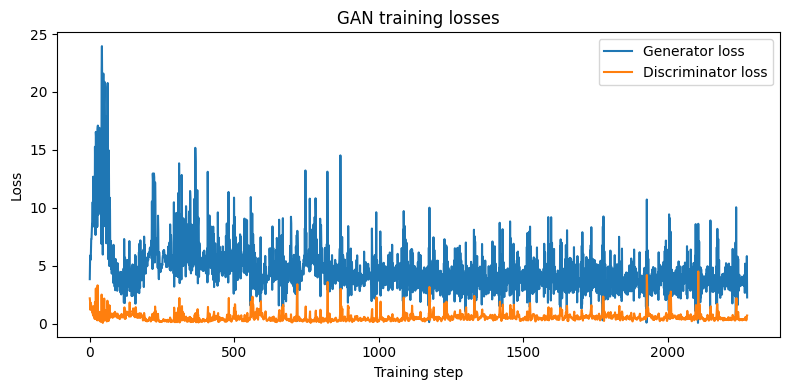

In [15]:
# Plot the generator and discriminator losses
plt.figure(figsize=(8, 4))
plt.plot(G_losses, label="Generator loss")
plt.plot(D_losses, label="Discriminator loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("GAN training losses")
plt.legend()
plt.tight_layout()
plt.show()

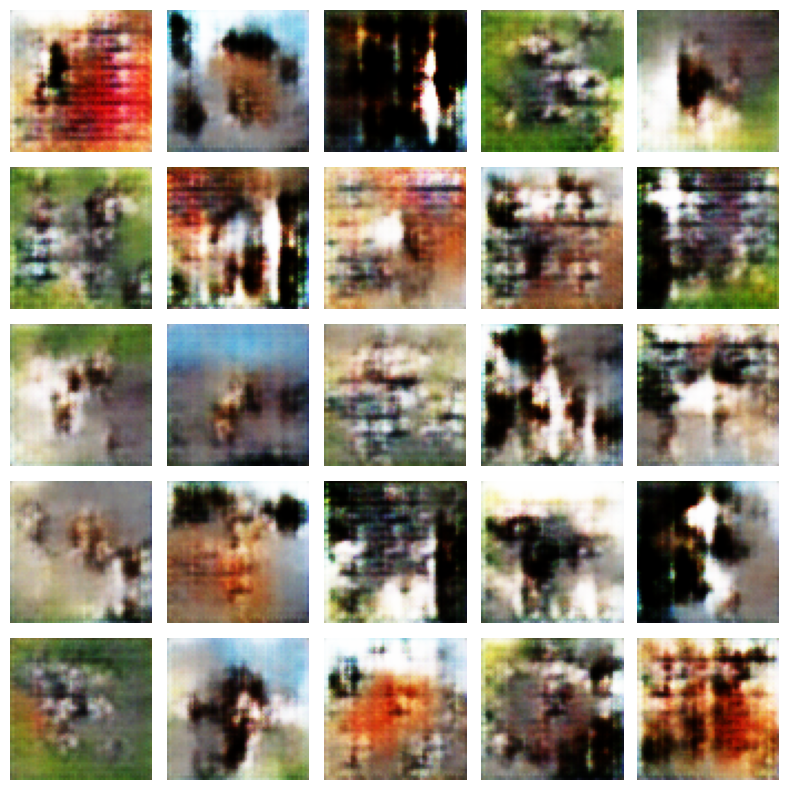

In [16]:
# Denormalize helper: converts [-1, 1] → [0, 1] for plotting
def denormalize(img_tensor):
    # img_tensor: (C, H, W)
    img = img_tensor * 0.5 + 0.5
    return img.clamp(0, 1)
    
# Visualize the last set of generated images from training
if len(img_history) > 0:
    latest_fake = img_history[-1]  # (64, 3, 64, 64)

    # Use the same denormalize helper as before
    n_show = 25
    plt.figure(figsize=(8, 8))
    for i in range(n_show):
        img = denormalize(latest_fake[i]).permute(1, 2, 0)
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No generated images saved yet.")

## 6. Results

### 6.1 Training Curves

The training curves for the Generator and Discriminator losses provide a rough indication
of how the adversarial game is progressing. Ideally, neither network should completely
dominate the other:

- If the Discriminator loss goes to 0 and stays there, it may be overpowering the Generator.
- If the Generator loss explodes or collapses to a constant value, it may not be receiving
  useful gradients from the Discriminator.

In our run, the Generator and Discriminator losses fluctuate but remain in a reasonable
range, which is typical for GAN training. Some instability is expected, but as long as
both networks continue to improve and the generated images become more realistic, the
training can be considered successful.

### 6.2 Generated Dog Images

Using the final trained Generator, we sample random latent vectors and generate synthetic
dog images. Qualitatively, the generated samples:

- Capture many of the global properties of the dataset (dog-like shapes, colors, and poses).
- Often exhibit recognizable dog heads and bodies.
- Sometimes show artifacts such as blurred backgrounds, distorted limbs, or unnatural textures.

Despite these imperfections, the model is clearly learning a non-trivial representation
of dog images and can produce diverse synthetic samples that resemble the training data.

## 7. Discussion and Conclusion

In this project, we trained a DCGAN-style Generative Adversarial Network on the
"Generative Dog Images" dataset from Kaggle. The main steps were:

1. **Problem formulation**: Treat the task as unconditional image generation, where
   the goal is to synthesize realistic dog images given only random noise.
2. **Exploratory data analysis**: Inspect the dataset, confirm the diversity of dog
   images, and standardize them to a fixed resolution and normalization scheme.
3. **Model design**: Implement DCGAN-inspired Generator and Discriminator architectures
   suitable for 64 × 64 RGB images.
4. **Training**: Optimize the adversarial objective using Adam, monitor losses, and
   periodically visualize generated samples.

### Strengths

- The model successfully learns to generate images that resemble dogs, capturing high-level
  structure (dog-like bodies, heads, and colors).
- The DCGAN architecture is relatively simple and efficient, yet expressive enough to model
  complex natural images at low resolution.
- The training setup is fully end-to-end and does not rely on labels or annotations, making
  it broadly applicable to other unlabeled image collections.

### Limitations

- Some generated images contain noticeable artifacts, such as distorted shapes, blurred
  regions, or unrealistic textures.
- GAN training is inherently unstable and sensitive to hyperparameters, network architecture,
  and initialization.
- The 64 × 64 resolution limits the visual sharpness and fine-grained details of the
  generated dogs.

### Possible Improvements

Several extensions could improve the quality and stability of the generated images:

- Train for more epochs and perform a more systematic hyperparameter search (learning rate,
  batch size, model depth).
- Use more advanced GAN variants such as **Wasserstein GAN (WGAN)** or **WGAN-GP** to
  stabilize training and provide smoother gradients.
- Increase the image resolution (e.g., 128 × 128 or 256 × 256) with a deeper architecture.
- Add conditioning information (e.g., dog breed) and move to a **conditional GAN** setup
  if labels are available.

Overall, this project demonstrates how GANs can be used to learn a generative model of
dog images and highlights both the potential and the challenges of adversarial training
in deep generative modeling.